In [28]:
import torch
import os
import numpy as np
import pandas as pd
import torch
import torchmetrics
import random
import torchvision
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch import nn
from PIL import Image
from torchvision.models import efficientnet_b3
from torchvision.models import efficientnet_b5

BATCH_SIZE = 28
NUM_WORKERS = 2
RESIZING = 224

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device('cpu')
    print('No GPU, Using CPU instead')

Using GPU: Tesla T4


Достанем данные из папки и посчитаем, какая выборка изображений нам доступна

In [29]:
def get_images(path):
    image_names_lst = os.listdir(path)
    train_df, test_df = pd.read_csv(path + '/train.csv'), pd.read_csv(path + '/test.csv')
    train_df.sort_values(by='image_id', ignore_index=True, inplace=True)
    image_names = sorted(os.listdir(path + '/train/'))
    train_images, test_images = [path + '/train/' + name for name in image_names], [path + '/test/' + name for name in os.listdir(path + '/test/')]
    labels = list(train_df['label'].values)
    return train_images, test_images, labels

train_images, test_images, labels = get_images('/kaggle/input/vk-made-sports-image-classification')
print('Train dataset:', len(train_images),', number of classes', len(np.unique(labels)), 'test dataset', len(test_images))

Train dataset: 45373 , number of classes 30 test dataset 19446


В описании сказано, что придется что-то делать с датасетом. Значит, данные не самые хорошие и классы не сбалансированы. Посчитаем всю выборку и посмотрим, какие классы в меньшенстве

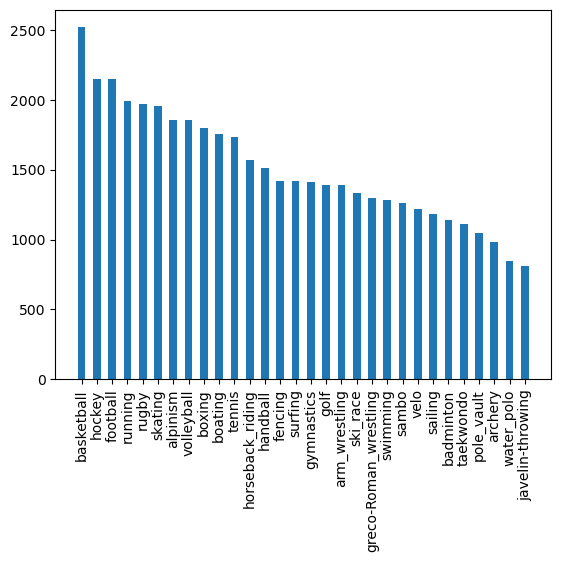

In [30]:
cnt = Counter(labels)
cnt_sorted = [(k, v) for k, v in sorted(cnt.items(), reverse=True, key=lambda x:x[1])]
sorted_labels = [pair[0] for pair in cnt_sorted]
sorted_values = [pair[1] for pair in cnt_sorted]
plt.bar(sorted_labels,  sorted_values, width=0.5)
plt.xticks(rotation=90);

Да, действительно, видим, что некоторые классы по количеству значительно отличаются от других. В любом случае, нам нужно будет проконтролировать, чтобы данные из маленьких классов попадали в обучающую и валидационные выборки.
Для начала подготовим все к обучению модели, закодируем лейблы  

In [31]:
# Преобразуем уникальные классы в id, который будем предсказывать, далее закодируем трейн выборку 
def label_encode(labels):
    unique_labels = np.unique(labels)
    class_to_id = {cls: i for (cls, i) in zip(unique_labels, range(len(unique_labels)))}
    id_to_class = {i : cls for (i, cls) in zip(range(len(unique_labels)), unique_labels)}    
    return class_to_id, id_to_class

# воспользуемся функцией для просмотра картинок тренировочного даталоадера из лекции 
# https://github.com/lysukhin/vk-academy-dl-cv/tree/2022/computer_vision
def imshow(inp, title=None, figsize=(16, 9)):
    """Imshow for Tensor."""
    plt.figure(figsize=figsize)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
    
original_labels = labels
class_to_id, id_to_class = label_encode(labels)
labels = [class_to_id[label] for label in labels]

Так как данные не сбалансированы по классам, первая идея - это взять одинаковое количество данных из каждого датасета, которое нам позволяет самый маленький по численности класс и дальше уже решать по ходу, нужно ли раздувать выборку искусственно или данных нам хватит. Из предыдущего блока мы узнали, что в наименьшем классе около 800-820 картинок, ограничим количество картинок в каждом из классов этим числом, ну или первой 1000. 

In [32]:
data = pd.DataFrame(train_images, columns=['name'])
data['labels'] = labels
data['flg'] = 0
cnts = [0 for i in range(len(class_to_id))]
for i in range(len(data)):
    img = data.name.iloc[i]
    w, h = Image.open(img).size
    lbl = data.labels.iloc[i]
    if cnts[lbl] <= 1000:
        cnts[lbl] += 1
        data.flg.iloc[i] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Посмотрим на получившуюся выборку

In [33]:
downsampled_train_images = list(data[data.flg == 1].name)
downsampled_train_labels = list(data[data.flg == 1].labels)
len(downsampled_train_labels)

29670

Самое главное проверить, сработала ли идея - получили ли мы примерно одинаковое количество изображений в каждом из классов, в 2х классах, как мы знаем, будет около 800-820 изображений. Вот так выглядит наша итоговая обучающая выборка классов

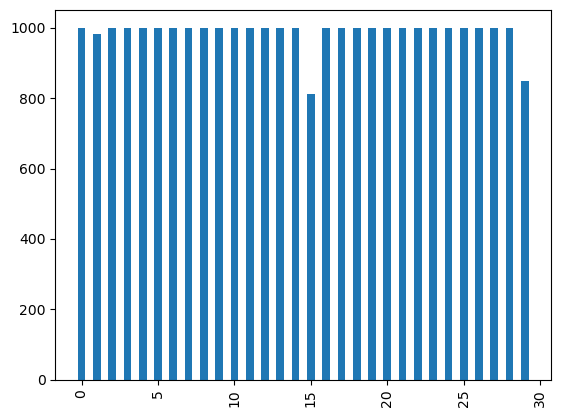

In [34]:
cnt = Counter(downsampled_train_labels)
cnt_sorted = [(k, v) for k, v in sorted(cnt.items(), reverse=True, key=lambda x:x[1])]
sorted_labels = [pair[0] for pair in cnt_sorted]
sorted_values = [pair[1] for pair in cnt_sorted]
plt.bar(sorted_labels,  sorted_values, width=0.5)
plt.xticks(rotation=90);

Подготовим данные для обучения модели - создадим тренировочную и валидационную выборки из размеченных картинок

In [35]:
train_imgs, val_imgs, train_labels, val_labels = train_test_split(downsampled_train_images, downsampled_train_labels, test_size=0.25, random_state=1234)
print(len(train_imgs), len(val_imgs))

22252 7418


In [36]:
class TochDataset(Dataset):
    def __init__(self, image_paths, labels, transform_composed=None):
        self.img_paths = image_paths
        self.labels = labels
        self.transforms = transform_composed
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transforms(img)
        return {
            'image': img_tensor, 
            'label': torch.tensor(label).long()
        }

Так как нам нужно побить довольно высокий бейзлайн добавим побольше аугментаций! Начнем с тех, которые использовались в лекциях, будем проверять, как выглядят картинки, чтобы случайно не испортить процесс обучения модели. Кажется, что все аугментации можно представить в реальной жизни - например, спортсмен может быть снят под разными ракурсами, под разным наклоном - добавляем поворот картинок и горизонтальное отображение. На всякий случай добавим еще и черно-белый фильтр, такие картинки тоже могут встретиться. Или же, например, условия съемки могут быть такими, будто фотография уже в чб - например темная фигура альпиниста на фоне белого снега или же фото в контровом свете. Так как мы будем использовать предобученную модель b3, добавим сразу же ресайзинг картинок под подходящий размер (указан в спецификации к модели).

In [37]:
train_transforms = transforms.Compose([
    transforms.Resize((RESIZING, RESIZING)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomHorizontalFlip(0.3), 
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((RESIZING, RESIZING)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TochDataset(train_imgs, train_labels, transform_composed = train_transforms)
val_dataset = TochDataset(val_imgs, val_labels, transform_composed = val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=False)

Так как мы использовали много аугментаций, посмотрим, как они повлияли на картинки - действительно ли картинки различимы. Если что можем подправить аугментации, но кажется, что картинки вполне читаемы 

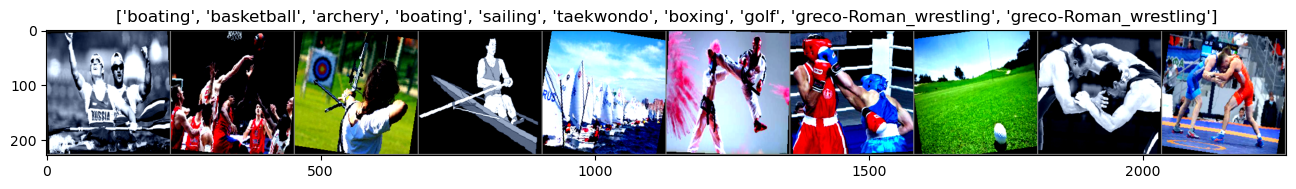

In [11]:
class_names = train_dataset.labels
data = next(iter(train_dataloader))
out = torchvision.utils.make_grid(data['image'][:10], nrow=10)
imshow(out, title=[id_to_class[x] for x in list(np.array(data['label']))[:10]])

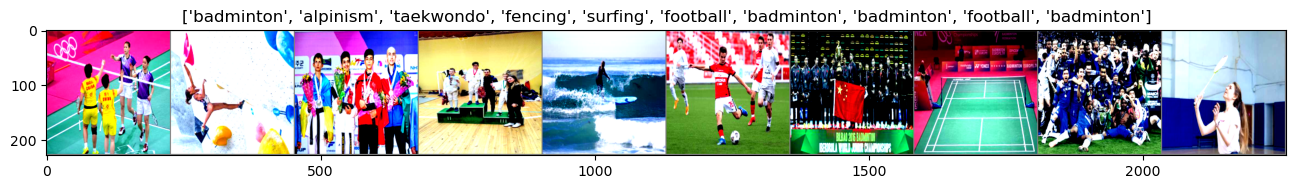

In [12]:
class_names = val_dataset.labels
data = next(iter(val_dataloader))
out = torchvision.utils.make_grid(data['image'][:10], nrow=10)
imshow(out, title=[id_to_class[x] for x in list(np.array(data['label']))[:10]])

Напишем скрипты для обучения модели. Так как модель предобученная, нам не нужно будет обучать ее всю, обучаться должен только последний слой, попробуем это отобразить в том числе в коде. 

In [38]:
def train_one_epoch(model, train_dataloader, optimizer, criterion):
    train_losses = 0
    model.train()
    # хоть модель и перевели в режим обучения, веса предобученной модели не должны меняться
    for module in model.modules():
        module.requires_grad = False
    model.fc.requires_grad = True
    
    all_preds = []
    for data in tqdm(train_dataloader):
        imgs, labels = data['image'], data['label']
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        y_pred = model(imgs)
        loss = criterion(y_pred, labels)
        train_losses += loss.item()
        loss.backward()
        optimizer.step()
        all_preds.append(y_pred)
    train_epoch_loss = train_losses / len(train_dataloader) # ошибка на всей выборке
    return all_preds, train_epoch_loss

def predict(model, val_dataloader, criterion):
    pred_losses = 0
    losses, all_preds = [], []
    model.eval()
    with torch.no_grad():
        for data in tqdm(val_dataloader):
            imgs, labels = data['image'], data['label']
            imgs, labels =  imgs.to(DEVICE), labels.to(DEVICE)
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            pred_losses += loss.item()
            all_preds.append(y_pred)
    val_epoch_loss = pred_losses / len(val_dataloader)
    return all_preds, val_epoch_loss

Размер линейного слоя также взят из спецификации модели. Приступим к обучению 

In [39]:
model = torchvision.models.efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(in_features=1536, out_features=len(class_to_id)) # TODO 1536 for model b3

In [41]:
from sklearn.metrics import f1_score

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()
EPOCHS = 150

model.to(DEVICE)
for epoch in range(EPOCHS):
    answers_val = []
    answers_train = []
    
    t_pred, t_los = train_one_epoch(model, train_dataloader, optimizer, criterion)
    v_pred, v_los = predict(model, val_dataloader, criterion)
    for vp in v_pred:
        vp = list(torch.argmax(torch.softmax(vp.cpu(), 1), 1).numpy())
        answers_val.extend(vp) 
    
    f1 = f1_score(val_labels, answers_val, average='micro')
    acc_val = round(accuracy_score(answers_val, val_labels), 4)    
    learn_rate = optimizer.state_dict()['param_groups'][0]['lr']
    print(f'Epoch: {epoch}, train_loss={t_los}, valid_loss={v_los}, f1={f1}, val_accuracy={acc_val}, lr={learn_rate}')
    scheduler.step(v_los)

100%|██████████| 265/265 [00:40<00:00,  6.58it/s]


Epoch: 0, train_loss=1.15539912431495, valid_loss=0.5859623747051886, f1=0.8370180641682394, val_accuracy=0.837, lr=0.001


100%|██████████| 265/265 [00:39<00:00,  6.68it/s]


Epoch: 1, train_loss=0.6519862167958943, valid_loss=0.5573380497828969, f1=0.8603397142086816, val_accuracy=0.8603, lr=0.001


100%|██████████| 265/265 [00:39<00:00,  6.66it/s]


Epoch: 2, train_loss=0.5321804504724419, valid_loss=1.014672636219634, f1=0.8522512806686439, val_accuracy=0.8523, lr=0.001


100%|██████████| 265/265 [00:39<00:00,  6.77it/s]


Epoch: 3, train_loss=0.46111298137865725, valid_loss=0.5136996856627037, f1=0.8678889188460501, val_accuracy=0.8679, lr=0.001


100%|██████████| 265/265 [00:39<00:00,  6.69it/s]


Epoch: 4, train_loss=0.3945259782409518, valid_loss=0.5526387388835539, f1=0.8642491237530332, val_accuracy=0.8642, lr=0.001


100%|██████████| 265/265 [00:40<00:00,  6.62it/s]


Epoch: 5, train_loss=0.3628568710009538, valid_loss=0.5395736294534971, f1=0.8643839309787005, val_accuracy=0.8644, lr=0.001


100%|██████████| 265/265 [00:41<00:00,  6.37it/s]


Epoch: 6, train_loss=0.32665430714007254, valid_loss=0.5262978157133988, f1=0.8720679428417363, val_accuracy=0.8721, lr=0.001


100%|██████████| 265/265 [00:39<00:00,  6.76it/s]


Epoch: 7, train_loss=0.28881025133923915, valid_loss=0.5117475988413647, f1=0.8769210029657589, val_accuracy=0.8769, lr=0.001


100%|██████████| 265/265 [00:41<00:00,  6.44it/s]


Epoch: 8, train_loss=0.2586256267784058, valid_loss=0.5498617448264136, f1=0.873281207872742, val_accuracy=0.8733, lr=0.001


100%|██████████| 265/265 [00:39<00:00,  6.75it/s]


Epoch: 9, train_loss=0.23925711701407373, valid_loss=0.5871460881013916, f1=0.865057967107037, val_accuracy=0.8651, lr=0.001


100%|██████████| 265/265 [00:41<00:00,  6.44it/s]


Epoch: 10, train_loss=0.22981051254179916, valid_loss=0.5584458812368366, f1=0.8759773523860879, val_accuracy=0.876, lr=0.001


100%|██████████| 265/265 [00:41<00:00,  6.44it/s]


Epoch: 11, train_loss=0.20360152792630706, valid_loss=0.615200986481219, f1=0.8665408465893772, val_accuracy=0.8665, lr=0.001
Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 265/265 [00:40<00:00,  6.48it/s]


Epoch: 12, train_loss=0.0988237189708875, valid_loss=0.5307602193557991, f1=0.8943111350768401, val_accuracy=0.8943, lr=0.0005


100%|██████████| 265/265 [00:39<00:00,  6.68it/s]


Epoch: 13, train_loss=0.06294808092251795, valid_loss=0.5740510123474347, f1=0.8873011593421406, val_accuracy=0.8873, lr=0.0005


100%|██████████| 265/265 [00:40<00:00,  6.58it/s]


Epoch: 14, train_loss=0.062139363012898206, valid_loss=0.5888959818427398, f1=0.8868967376651389, val_accuracy=0.8869, lr=0.0005


100%|██████████| 265/265 [00:40<00:00,  6.49it/s]


Epoch: 15, train_loss=0.06404010650277893, valid_loss=0.5594582127556557, f1=0.8902669183068213, val_accuracy=0.8903, lr=0.0005
Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 265/265 [00:41<00:00,  6.41it/s]


Epoch: 16, train_loss=0.037818281114344494, valid_loss=0.5599563723728763, f1=0.9003774602318685, val_accuracy=0.9004, lr=0.00025


100%|██████████| 265/265 [00:40<00:00,  6.56it/s]


Epoch: 17, train_loss=0.02451725287016799, valid_loss=0.5866955794402803, f1=0.9011863035858722, val_accuracy=0.9012, lr=0.00025


100%|██████████| 265/265 [00:40<00:00,  6.48it/s]


Epoch: 18, train_loss=0.024094422651164134, valid_loss=0.6115617834759177, f1=0.8986249662981936, val_accuracy=0.8986, lr=0.00025


100%|██████████| 265/265 [00:40<00:00,  6.48it/s]


Epoch: 19, train_loss=0.021838675507673967, valid_loss=0.616648443254976, f1=0.8966028579131842, val_accuracy=0.8966, lr=0.00025
Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.


100%|██████████| 265/265 [00:40<00:00,  6.50it/s]


Epoch: 20, train_loss=0.018363229112885234, valid_loss=0.5961433593497858, f1=0.9015907252628741, val_accuracy=0.9016, lr=0.000125


100%|██████████| 265/265 [00:39<00:00,  6.67it/s]


Epoch: 21, train_loss=0.01335659962078467, valid_loss=0.5914363771428811, f1=0.9021299541655433, val_accuracy=0.9021, lr=0.000125


100%|██████████| 265/265 [00:40<00:00,  6.52it/s]


Epoch: 22, train_loss=0.012956482425169894, valid_loss=0.6008114490261025, f1=0.9038824480992181, val_accuracy=0.9039, lr=0.000125


100%|██████████| 265/265 [00:39<00:00,  6.64it/s]


Epoch: 23, train_loss=0.009199670421177138, valid_loss=0.6191132110718172, f1=0.9025343758425451, val_accuracy=0.9025, lr=0.000125
Epoch 00024: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 265/265 [00:40<00:00,  6.56it/s]


Epoch: 24, train_loss=0.008970666968828785, valid_loss=0.6132623343151897, f1=0.9059045564842275, val_accuracy=0.9059, lr=6.25e-05


100%|██████████| 265/265 [00:40<00:00,  6.58it/s]


Epoch: 25, train_loss=0.008049081052963314, valid_loss=0.5978739877328615, f1=0.9060393637098948, val_accuracy=0.906, lr=6.25e-05


100%|██████████| 265/265 [00:40<00:00,  6.48it/s]


Epoch: 26, train_loss=0.007890266508808775, valid_loss=0.5963976357109133, f1=0.9083310865462388, val_accuracy=0.9083, lr=6.25e-05


100%|██████████| 265/265 [00:40<00:00,  6.47it/s]


Epoch: 27, train_loss=0.007143923271219394, valid_loss=0.5881733181827619, f1=0.9098139660285791, val_accuracy=0.9098, lr=6.25e-05
Epoch 00028: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 265/265 [00:40<00:00,  6.51it/s]


Epoch: 28, train_loss=0.005416248311010338, valid_loss=0.6072446182299622, f1=0.9096791588029118, val_accuracy=0.9097, lr=3.125e-05


100%|██████████| 265/265 [00:40<00:00,  6.59it/s]


Epoch: 29, train_loss=0.005650387631839345, valid_loss=0.5982142648606381, f1=0.9099487732542464, val_accuracy=0.9099, lr=3.125e-05


100%|██████████| 265/265 [00:40<00:00,  6.47it/s]


Epoch: 30, train_loss=0.005986207130099187, valid_loss=0.6028584667183305, f1=0.9094095443515773, val_accuracy=0.9094, lr=3.125e-05


100%|██████████| 265/265 [00:40<00:00,  6.61it/s]


Epoch: 31, train_loss=0.0052492582639285315, valid_loss=0.6038664264008096, f1=0.9095443515772446, val_accuracy=0.9095, lr=3.125e-05
Epoch 00032: reducing learning rate of group 0 to 1.5625e-05.


100%|██████████| 265/265 [00:40<00:00,  6.59it/s]


Epoch: 32, train_loss=0.004573349123739552, valid_loss=0.6102657469516655, f1=0.9073874359665678, val_accuracy=0.9074, lr=1.5625e-05


  8%|▊         | 61/795 [00:22<04:27,  2.75it/s]


KeyboardInterrupt: 

Мы захотим посмотреть, на каких картинках модель ошибается, поэтому получим предсказания на всем датасете. 

In [42]:
print('Всего в выборке картинок:', len(downsampled_train_images), len(downsampled_train_labels))
all_dataset = TochDataset(downsampled_train_images, downsampled_train_labels, transform_composed=val_transforms)
all_dataloader = DataLoader(all_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=False)

answers_all = []
a_pred, a_los = predict(model, all_dataloader, criterion)
for vp in a_pred:
    vp = list(torch.argmax(torch.softmax(vp.cpu(), 1), 1).numpy())
    answers_all.extend(vp) 
f1 = f1_score(downsampled_train_labels, answers_all, average='micro')
print(f'f1={f1}')

Всего в выборке картинок: 29670 29670


100%|██████████| 1060/1060 [02:40<00:00,  6.59it/s]


f1=0.9768115942028985


Посмотрим, какие лейблы мы хуже всего предсказываем

In [43]:
result = pd.DataFrame(downsampled_train_labels, columns=['y_true'])
result['y_pred'] = answers_all
result['image'] = downsampled_train_images
top_5_wrong = list(result[result.y_true != result.y_pred].y_true.value_counts()[:5].index)
print('Классы, на которых модель чаще всего ошибается', top_5_wrong, 'это лейблы', [id_to_class[i] for i in top_5_wrong]) 

Классы, на которых модель чаще всего ошибается [12, 4, 8, 18, 6] это лейблы ['handball', 'basketball', 'football', 'running', 'boxing']


In [44]:
print('Всего ошибок в классификации', len(result[result.y_true != result.y_pred]))
print('больше всего ошибок в классах:', result[result.y_true != result.y_pred].y_true.value_counts()[:5])

Всего ошибок в классификации 688
больше всего ошибок в классах: 12    51
4     43
8     43
18    41
6     38
Name: y_true, dtype: int64


Сохраним себе данные примеры ошибочных классификаций, чтобы посмотреть пристальнее на картинки

In [45]:
wrong_imgs = list(result[(result.y_true != result.y_pred)].image.values)
wrong_true_lbl = list(result[(result.y_true != result.y_pred)].y_true.values)
wrong_pred_lbl = list(result[(result.y_true != result.y_pred)].y_pred.values)

In [46]:
wrong = pd.DataFrame(wrong_imgs, columns=['name'])
wrong['true_lbl'] = wrong_true_lbl
wrong['pred_lbl'] =  list(result[(result.y_true != result.y_pred)].y_pred.values)
create_download_link(wrong)

Проверим картинки, на которых модель ошиьается, возможно, картинки сами по себе неверно размечены, или же картинки мусорные, не представляющие свой класс

In [130]:
data = pd.DataFrame(downsampled_train_images, columns=['name'])
data['label'] = downsampled_train_labels
data['correct_label'] = downsampled_train_labels

Посмотрели на картинки, лично мне совсем не очевидно, как модель должна понимать, какой спорт в ней по картинкам вроде той, что ниже :) 
Также в датасете действительно присутствует ошибочная разметка, мусорные картинки даже, бывает, хуже этой. Как минимум было замечено несколько картинок с соревнований по шахматам, при том, что такого класса в датасете нет. Разметка таких картинок была 'arm-wrestling'

class 4 label basketball  my prediction 3 badminton


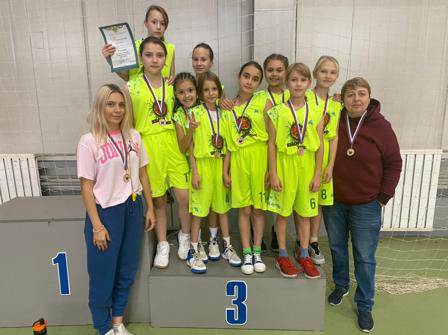

In [372]:
i = 200
# 24, 35, 40, 42, 46, 47, 49, 50, 54, 61, 62, 63, 66, 67, 68, 78, 86, 88, 90, 91, 92, 95, 96, 97, 99, 106, 111, 114, 115, 121, 124, 126, 127, 131, 133, 136, 137, 138, 142, 152, 159, 161, 164, 169, 173, 175, 181, 188, 193, 194, 195, 198, 200
lbl = wrong_true_lbl[i]
pred = wrong_pred_lbl[i]
print('class', lbl, 'label', id_to_class[lbl], ' my prediction', pred, id_to_class[pred])
Image.open(wrong_imgs[i]).convert('RGB')

In [ ]:
cond = data.name == wrong_imgs[i]
data.loc[cond, ['correct_label']] = 6
data.loc[cond]

Попробуем побороться с такими картинками и дообучить модель. Было исправлено около 60 лейблов из выборки по причине неправильной разметки класса. Спойлер! У меня не получилось достичь какого-либо значимого улучшения при обучении модели на исправленном датасете (исправлены некорректные лейблы), поэтому ниже будет сразу код подготовки данных для сабмита, а дальше пример того, как я обучала модель на исправленных лейблах. Думаю, причина отсутствия улучшения в том, что 60 картинок с некорректными лейблами - это мало для такого большого датасета. Тем более не все из них были в трейн выборке.

In [379]:
df = pd.DataFrame(data[data.label != data.correct_label])
create_download_link(df)

In [385]:
for name, lbl in zip(list(data[data.label != data.correct_label].name.values), list(data[data.label != data.correct_label].correct_label.values)):
    flg = 0
    for i, train_img in enumerate(train_imgs):
        if train_img == name:
            train_labels[i] = lbl
            flg = 1
    if not flg:
        for i, test_img in enumerate(test_images):
            if test_img == name:
                test_labels = lbl
                flg = 1

### Завершающая часть - подготовка файла для сабмита

In [47]:
# Делаем предсказание моделью, которое уже пойдет в сабмит - предсказание на тестовой выборке
test_labels = labels[:len(test_images)]
print(len(test_labels), len(test_images))

test_dataset = TochDataset(test_images, test_labels, transform_composed=val_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=False)

test_pred, test_los = predict(model, test_dataloader, criterion)
answers_test = []  

for vp in test_pred:
    vp = list(torch.argmax(torch.softmax(vp.cpu(), 1), 1).numpy())
    answers_test.extend(vp) 

19446 19446


100%|██████████| 695/695 [01:43<00:00,  6.74it/s]


In [48]:
train_images, test_images, labels = get_images('/kaggle/input/vk-made-sports-image-classification')
original_labels = labels
class_to_id, id_to_class = label_encode(labels)
labels = [class_to_id[label] for label in labels]

In [49]:
image_id = [name.split('/')[-1] for name in test_images]
df_sub = pd.DataFrame(image_id, columns=['image_id'])
df_sub['label'] = [id_to_class[answers_test[i]] for i in range(len(answers_test))]
df_sub.head(4)

,image_id,label
0,66f867a8-796c-4e3e-84ad-b55b60d0742d.jpeg,running
1,63c1f328-be56-4ada-b709-c14a1230189f.jpeg,horseback_riding
2,a3237adb-e5fe-4ea4-b258-588c06235319.jpeg,volleyball
3,396648f9-7486-44cb-aa3d-ae62627e414d.jpeg,taekwondo


In [50]:
import base64
from IPython.display import HTML
    
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

### Файл сабмита в кэггл

In [51]:
create_download_link(df_sub)

### Попробуем исправить неверные лейблы и обучить модель заново еще раз

In [23]:
path = '/kaggle/input/wrong-lbls/'
wrong_lbls = pd.read_csv(path + 'wrong_lbl.csv')
wrong_labtls_corrected = pd.read_csv(path + 'wrong_labels_corrected.csv')

class 1 label archery  my prediction 2 arm_wrestling


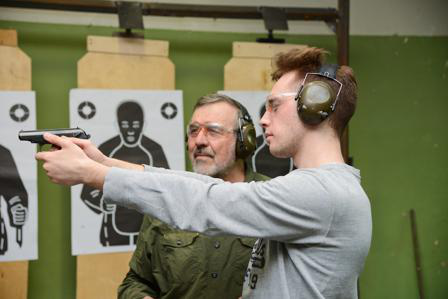

In [720]:
i = 651
# 24, 40, 90, 111, 152,  173, 198, 221, 296, 304, 334, 429,434, 460, 493, 495, 519, 520, 529, 534, 565, 597, 651
lbl = wrong_lbls.true_lbl[i]
pred = wrong_lbls.pred_lbl[i]
print('class', lbl, 'label', id_to_class[lbl], ' my prediction', pred, id_to_class[pred])
Image.open(wrong_lbls.name[i]).convert('RGB')

Опять картинка, которая не относится ни к одному классу из представленных. В идеальном случае такие картинки нужно,наверное, удалять. Но я решил не править ничего, кроме лейблов, потому что, возможно в тестовой выборке присутствует такой же мусор

In [704]:
cond = wrong_lbls.name == wrong_lbls.loc[i][0]
wrong_lbls.loc[cond, ['correct_lbl']] = 4

In [739]:
# Исправим разметки в трейн и тестовой выборке
for name, lbl in zip(list(wrong_lbls[wrong_lbls['true_lbl'] != wrong_lbls['correct_lbl']].name.values), list(wrong_lbls[wrong_lbls['true_lbl'] != wrong_lbls['correct_lbl']].correct_lbl.values)):
    flg = 0
    for i, train_img in enumerate(train_imgs):
        if train_img == name:
            train_labels[i] = lbl
            flg = 1
    if not flg:
        for i, test_img in enumerate(test_images):
            if test_img == name:
                test_labels = lbl
                flg = 1

In [743]:
create_download_link(wrong_lbls)

### Обучим модель заново

In [18]:
from sklearn.metrics import f1_score

model = efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(in_features=1536, out_features=len(class_to_id)) # TODO 1536 for model

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
criterion = nn.CrossEntropyLoss()
EPOCHS = 150

model.to(DEVICE)
for epoch in range(EPOCHS):
    answers_val = []
    answers_train = []
    
    t_pred, t_los = train_one_epoch(model, train_dataloader, optimizer, criterion)
    v_pred, v_los = predict(model, val_dataloader, criterion)
    for vp in v_pred:
        vp = list(torch.argmax(torch.softmax(vp.cpu(), 1), 1).numpy())
        answers_val.extend(vp) 
    
    f1 = f1_score(val_labels, answers_val, average='micro')
    acc_val = round(accuracy_score(answers_val, val_labels), 4)    
    learn_rate = optimizer.state_dict()['param_groups'][0]['lr']
    print(f'Epoch: {epoch}, train_loss={t_los}, valid_loss={v_los}, f1={f1}, val_accuracy={acc_val}, lr={learn_rate}')
    scheduler.step(v_los)

100%|██████████| 265/265 [00:41<00:00,  6.38it/s]


Epoch: 0, train_loss=1.1915180839832473, valid_loss=0.6467865220499489, f1=0.821784847667835, val_accuracy=0.8218, lr=0.001


100%|██████████| 265/265 [00:37<00:00,  6.99it/s]


Epoch: 1, train_loss=0.6638754044782441, valid_loss=0.5295136592579338, f1=0.8569695335669992, val_accuracy=0.857, lr=0.001


100%|██████████| 265/265 [00:38<00:00,  6.95it/s]


Epoch: 2, train_loss=0.5387135900510183, valid_loss=0.5304896325154125, f1=0.8595308708546778, val_accuracy=0.8595, lr=0.001


100%|██████████| 265/265 [00:41<00:00,  6.44it/s]


Epoch: 3, train_loss=0.44932790072927686, valid_loss=0.5110201602415094, f1=0.8678889188460501, val_accuracy=0.8679, lr=0.001


100%|██████████| 265/265 [00:39<00:00,  6.79it/s]


Epoch: 4, train_loss=0.4034175102862547, valid_loss=0.5365395739252837, f1=0.8680237260717174, val_accuracy=0.868, lr=0.001


100%|██████████| 265/265 [00:41<00:00,  6.38it/s]


Epoch: 5, train_loss=0.3599432786657188, valid_loss=0.5283537588205259, f1=0.8666756538150445, val_accuracy=0.8667, lr=0.001


100%|██████████| 265/265 [00:40<00:00,  6.60it/s]


Epoch: 6, train_loss=0.31417754935393544, valid_loss=0.5754834877485233, f1=0.8608789431113507, val_accuracy=0.8609, lr=0.001
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 265/265 [00:39<00:00,  6.65it/s]


Epoch: 7, train_loss=0.1563086631699061, valid_loss=0.4374582127149586, f1=0.8995686168778646, val_accuracy=0.8996, lr=0.0001


100%|██████████| 265/265 [00:41<00:00,  6.45it/s]


Epoch: 8, train_loss=0.09252633870924887, valid_loss=0.4423697549709172, f1=0.9048260986788892, val_accuracy=0.9048, lr=0.0001


100%|██████████| 265/265 [00:39<00:00,  6.79it/s]


Epoch: 9, train_loss=0.07173661865211976, valid_loss=0.44697308750858283, f1=0.906578592612564, val_accuracy=0.9066, lr=0.0001


100%|██████████| 265/265 [00:39<00:00,  6.64it/s]


Epoch: 10, train_loss=0.05739516911752897, valid_loss=0.4655893949545779, f1=0.9056349420328931, val_accuracy=0.9056, lr=0.0001
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 265/265 [00:39<00:00,  6.79it/s]


Epoch: 11, train_loss=0.04323233861791749, valid_loss=0.4527859505230807, f1=0.9077918576435697, val_accuracy=0.9078, lr=1e-05


100%|██████████| 265/265 [00:40<00:00,  6.62it/s]


Epoch: 12, train_loss=0.040097457346775126, valid_loss=0.45868995424781767, f1=0.9060393637098948, val_accuracy=0.906, lr=1e-05


100%|██████████| 265/265 [00:41<00:00,  6.34it/s]


Epoch: 13, train_loss=0.03976943919697993, valid_loss=0.4546419061404073, f1=0.9077918576435697, val_accuracy=0.9078, lr=1e-05
Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 265/265 [00:39<00:00,  6.67it/s]


Epoch: 14, train_loss=0.040022005361128515, valid_loss=0.45731370902690544, f1=0.906578592612564, val_accuracy=0.9066, lr=1.0000000000000002e-06


100%|██████████| 265/265 [00:41<00:00,  6.39it/s]


Epoch: 15, train_loss=0.03809473649283824, valid_loss=0.4528004778399712, f1=0.9075222431922351, val_accuracy=0.9075, lr=1.0000000000000002e-06


100%|██████████| 265/265 [00:39<00:00,  6.65it/s]


Epoch: 16, train_loss=0.038002448762567864, valid_loss=0.45426863701662645, f1=0.9094095443515773, val_accuracy=0.9094, lr=1.0000000000000002e-06
Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 265/265 [00:40<00:00,  6.57it/s]


Epoch: 17, train_loss=0.03889944900713902, valid_loss=0.4578608025568274, f1=0.9059045564842275, val_accuracy=0.9059, lr=1.0000000000000002e-07


100%|██████████| 265/265 [00:40<00:00,  6.57it/s]


Epoch: 18, train_loss=0.037240116259100724, valid_loss=0.45296551142555647, f1=0.9080614720949043, val_accuracy=0.9081, lr=1.0000000000000002e-07


100%|██████████| 265/265 [00:41<00:00,  6.39it/s]


Epoch: 19, train_loss=0.03612990095968353, valid_loss=0.459349076552668, f1=0.9083310865462388, val_accuracy=0.9083, lr=1.0000000000000002e-07
Epoch 00020: reducing learning rate of group 0 to 1.0000e-08.


  2%|▏         | 18/795 [00:07<05:31,  2.34it/s]


KeyboardInterrupt: 

Данный файлик после обучения также был засабмичен в кэггл, но прироста скора, к сожалению, не получилось